# My Capstone Project: Battle of the cities in Denmark

## Import packages

In [89]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
#conda install -c anaconda seaborn

## Load data

In [29]:
link = "http://www.tageo.com/index-e-da-cities-DK.htm"
tables = pd.read_html(link,header = 0,skiprows = 0)
df_list = [tables[16]]

link = "http://www.tageo.com/index-e-da-cities-DK-step-1.htm"
tables = pd.read_html(link,header = 0,skiprows = 0)
df_list.append(tables[16])

link = "http://www.tageo.com/index-e-da-cities-DK-step-2.htm"
tables = pd.read_html(link,header = 0,skiprows = 0)
df_list.append(tables[16])

link = "http://www.tageo.com/index-e-da-cities-DK-step-3.htm"
tables = pd.read_html(link,header = 0,skiprows = 0)
df_list.append(tables[16])

link = "http://www.tageo.com/index-e-da-cities-DK-step-4.htm"
tables = pd.read_html(link,header = 0,skiprows = 0)
df_list.append(tables[16])

df = pd.concat(df_list,ignore_index = True).drop(['Rank'],axis = 1)
df.reset_index()
df.head()

City  Population (2000)  Latitude (DD)  Longitude (DD)
0  Kobenhavn            1089700          55.68           12.57
1      Arhus             224400          56.16           10.21
2     Odense             145600          55.40           10.38
3    Aalborg             121500          57.03            9.93
4    Esbjerg              72500          55.47            8.45

In [30]:
df.columns = ['City name','Population','Latitude','Longitude']
df.tail()

City name  Population  Latitude  Longitude
295   Vindinge        2000     55.63      12.15
296      Vekso        1900     55.75      12.25
297    Ulstrup        1900     56.40       9.80
298     Holeby        1900     54.72      11.47
299  Engesvang        1900       NaN        NaN

In [210]:
df[df['Population'] == df['Population'].min()]

City name  Population  Latitude  Longitude
296     Vekso        1900     55.75      12.25
297   Ulstrup        1900     56.40       9.80
298    Holeby        1900     54.72      11.47

## Clean data

In [ ]:
df = df.dropna()
df.shape

In [33]:
# create map of Denmark using latitude and longitude values
Latitude_DK = 56.2639 
Longitude_DK = 10.5018
map_DK = folium.Map(location=[Latitude_DK, Longitude_DK], zoom_start=2)
R = 5

# add markers to map
for lat, lng, City, Population in zip(df['Latitude'], df['Longitude'], df['City name'], df['Population']):
    label = '{}, Pop:{}'.format(City, Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=R,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DK)  
    
map_DK

### Fix wrong location of Lemvig

In [34]:
df.loc[df['City name'] == 'Lemvig','Latitude'] = 56.5443

## Exploratory data analysis

In [35]:
df.describe()


Population    Latitude   Longitude
count  2.980000e+02  298.000000  298.000000
mean   1.330973e+04   55.857162   10.506980
std    6.551004e+04    0.654665    1.311002
min    1.900000e+03   54.650000    8.130000
25%    2.700000e+03   55.412500    9.555000
50%    3.850000e+03   55.750000   10.150000
75%    8.500000e+03   56.200000   11.787500
max    1.089700e+06   57.730000   15.150000

## Get venue data

### My Foursquare credentials

In [36]:
CLIENT_ID = '5EOMIPT15ID2GQDR0RXDCR4MVWLE2ECEB0JKTKKDAVQ1ZMKZ' # your Foursquare ID
CLIENT_SECRET = '03VHXRBYWMEE3G40J3QXSUINJXOU2R23OPLUIFCJA1PYBYTP' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5EOMIPT15ID2GQDR0RXDCR4MVWLE2ECEB0JKTKKDAVQ1ZMKZ
CLIENT_SECRET:03VHXRBYWMEE3G40J3QXSUINJXOU2R23OPLUIFCJA1PYBYTP


In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
# function that gets the venues in a radius around a given location 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(requests.get(url).json()['meta'])
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print(results.response['meta'])
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City name', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
radius = 10000
LIMIT = 30 # Limit of how many venues to find
venues = getNearbyVenues(names=df['City name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   radius = radius)

In [42]:
print(venues.shape)
venues.head(5)

(5640, 7)


City name  City Latitude  City Longitude                  Venue  \
0  Kobenhavn          55.68           12.57          Ørstedsparken   
1  Kobenhavn          55.68           12.57                  Väkst   
2  Kobenhavn          55.68           12.57          Torvehallerne   
3  Kobenhavn          55.68           12.57        Paludan Bogcafé   
4  Kobenhavn          55.68           12.57  The Coffee Collective   

   Venue Latitude  Venue Longitude           Venue Category  
0       55.680670        12.566367                     Park  
1       55.678770        12.566886  Scandinavian Restaurant  
2       55.683934        12.569244               Food Court  
3       55.680419        12.573238                     Café  
4       55.683695        12.569790              Coffee Shop

In [43]:
venues.groupby('City name').count()

City Latitude  City Longitude  Venue  Venue Latitude  \
City name                                                           
Aabenraa                21              21     21              21   
Aabybro                 10              10     10              10   
Aakirkeby                9               9      9               9   
Aalborg                 30              30     30              30   
Aalestrup                9               9      9               9   
...                    ...             ...    ...             ...   
Vissenbjerg             13              13     13              13   
Vodskov                 30              30     30              30   
Vojens                  12              12     12              12   
Vordingborg              4               4      4               4   
Vra                      6               6      6               6   

             Venue Longitude  Venue Category  
City name                                     
Aabenraa                  21              21  
Aabybro                   10              10  
Aakirkeby                  9               9  
Aalborg                   30              30  
Aalestrup                  9               9  
...                      ...             ...  
Vissenbjerg               13              13  
Vodskov                   30              30  
Vojens                    12              12  
Vordingborg                4               4  
Vra                        6               6  

[295 rows x 6 columns]

In [44]:
print('There are {} uniques venue catagories over all the country.'.format(len(venues['Venue Category'].unique())))

There are 242 uniques venue catagories over all the country.


## Perform clustering

### We implement one hot encoding to prepare the date for analysis

In [45]:
# one hot encoding
DK_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
DK_onehot['City name'] = venues['City name'] 

# move City column to the first column
fixed_columns = [DK_onehot.columns[-1]] + list(DK_onehot.columns[:-1])
DK_onehot = DK_onehot[fixed_columns]
DK_onehot.head()

City name  Airport  Airport Lounge  Airport Terminal  American Restaurant  \
0  Kobenhavn        0               0                 0                    0   
1  Kobenhavn        0               0                 0                    0   
2  Kobenhavn        0               0                 0                    0   
3  Kobenhavn        0               0                 0                    0   
4  Kobenhavn        0               0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  ...  \
0             0         0            0           0                    0  ...   
1             0         0            0           0                    0  ...   
2             0         0            0           0                    0  ...   
3             0         0            0           0                    0  ...   
4             0         0            0           0                    0  ...   

   Tunnel  University  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0       0           0                              0                      0   
1       0           0                              0                      0   
2       0           0                              0                      0   
3       0           0                              0                      0   
4       0           0                              0                      0   

   Water Park  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Zoo  
0           0           0           0         0          0    0  
1           0           0           0         0          0    0  
2           0           0           0         0          0    0  
3           0           0           0         0          0    0  
4           0           0           0         0          0    0  

[5 rows x 243 columns]

In [46]:
# Get shape
DK_onehot.shape

(5640, 243)

### We can now group the rows by City name and take the mean of the frequency of occurrence of each category

In [47]:
DK_grouped = DK_onehot.groupby('City name').mean().reset_index()
print(DK_grouped.shape)
DK_grouped.head()

(295, 243)


City name  Airport  Airport Lounge  Airport Terminal  American Restaurant  \
0   Aabenraa      0.0             0.0               0.0                  0.0   
1    Aabybro      0.0             0.0               0.0                  0.0   
2  Aakirkeby      0.0             0.0               0.0                  0.0   
3    Aalborg      0.0             0.0               0.0                  0.0   
4  Aalestrup      0.0             0.0               0.0                  0.0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  ...  \
0           0.0       0.0          0.0    0.000000                  0.0  ...   
1           0.0       0.0          0.0    0.000000                  0.0  ...   
2           0.0       0.0          0.0    0.000000                  0.0  ...   
3           0.0       0.0          0.0    0.033333                  0.0  ...   
4           0.0       0.0          0.0    0.000000                  0.0  ...   

   Tunnel  University  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0     0.0         0.0                            0.0                    0.0   
1     0.0         0.0                            0.0                    0.0   
2     0.0         0.0                            0.0                    0.0   
3     0.0         0.0                            0.0                    0.0   
4     0.0         0.0                            0.0                    0.0   

   Water Park  Waterfront  Whisky Bar  Wine Bar  Wine Shop       Zoo  
0         0.0    0.000000         0.0       0.0        0.0  0.000000  
1         0.0    0.000000         0.0       0.0        0.0  0.000000  
2         0.0    0.000000         0.0       0.0        0.0  0.000000  
3         0.0    0.033333         0.0       0.0        0.0  0.033333  
4         0.0    0.000000         0.0       0.0        0.0  0.000000  

[5 rows x 243 columns]

### Print each City along with the top 3 most common venue

In [48]:
giveOutput = False
num_top_venues = 3
for city in DK_grouped['City name']:
    if giveOutput == True:
        print("----"+ city +"----")
    temp = DK_grouped[DK_grouped['City name'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    if giveOutput == True:
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

### Let us put the 12 most common venues for each city in a dataframe

In [115]:
# Function to sort venues in decending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City name'] = DK_grouped['City name']

for ind in np.arange(DK_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DK_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head(5)

City name 1st Most Common Venue 2nd Most Common Venue  \
0   Aabenraa  Fast Food Restaurant           Gas Station   
1    Aabybro         Grocery Store                Bakery   
2  Aakirkeby         Grocery Store                   Pub   
3    Aalborg                  Café    Italian Restaurant   
4  Aalestrup     Convenience Store                 Diner   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Café     Convenience Store                 Hotel   
1        Discount Store  Gym / Fitness Center  Fast Food Restaurant   
2                  Park                  Café            Restaurant   
3                  Park     French Restaurant                Bakery   
4                Bakery         Train Station  Gym / Fitness Center   

  6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0         Grocery Store             Rest Area               Restaurant   
1              Pharmacy           Bus Station           Ice Cream Shop   
2        Scenic Lookout       Harbor / Marina  Scandinavian Restaurant   
3                   Zoo         Deli / Bodega             Concert Hall   
4                  Tree            Playground                  Stadium   

  9th Most Common Venue  ...       21th Most Common Venue  \
0        Discount Store  ...                  Event Space   
1     Electronics Store  ...                  Event Space   
2            Distillery  ...                      Dog Run   
3                   Pub  ...                   Waterfront   
4               Brewery  ...  Eastern European Restaurant   

        22th Most Common Venue       23th Most Common Venue  \
0            Electronics Store  Eastern European Restaurant   
1  Eastern European Restaurant                   Food Truck   
2          Dumpling Restaurant                    Drugstore   
3         Gym / Fitness Center                    Drugstore   
4            Electronics Store                   Food Court   

  24th Most Common Venue 25th Most Common Venue 26th Most Common Venue  \
0    Dumpling Restaurant              Drugstore                Dog Run   
1    Dumpling Restaurant              Drugstore                Dog Run   
2            Flower Shop         Discount Store                  Diner   
3                   Farm                Factory                Exhibit   
4    Dumpling Restaurant              Drugstore                Dog Run   

  27th Most Common Venue 28th Most Common Venue 29th Most Common Venue  \
0                   Hill          Historic Site         Farmers Market   
1             Distillery                  Diner           Dessert Shop   
2           Dessert Shop          Design Studio       Department Store   
3            Event Space               Gym Pool      Electronics Store   
4             Distillery         Discount Store           Dessert Shop   

        30th Most Common Venue  
0                        Diner  
1                Design Studio  
2                Deli / Bodega  
3  Eastern European Restaurant  
4                Design Studio  

[5 rows x 31 columns]

### We can now cluster the cities by K-means

In [157]:
# set number of clusters
kclusters = 5

# Drop te city name for the clustering
DK_grouped_clustering = DK_grouped.drop('City name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DK_grouped_clustering)

# check cluster labels generated for the first 10 rows in the dataframe
kmeans.labels_[0:10]

array([2, 0, 3, 2, 2, 0, 1, 4, 2, 2], dtype=int32)

Merge with the original data frame

In [158]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DK_merged = df

# merge DK_grouped with DK_data to add latitude/longitude for each neighborhood
DK_merged = DK_merged.merge(city_venues_sorted, on='City name')
DK_merged.head()

ValueError: cannot insert Cluster Labels, already exists

### We can now finally visualize the results on our map of Denmark

In [159]:
# create map of Denmark using latitude and longitude values
map_clusters = folium.Map(location=[Latitude_DK, Longitude_DK], zoom_start=7)
R = 5

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DK_merged['Latitude'], DK_merged['Longitude'], DK_merged['City name'], DK_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Include the region data in the analysis and do some more exploratorry data analysis

In [160]:
# download regions geojson file
!wget --quiet https://raw.githubusercontent.com/Neogeografen/dagi/master/geojson/regioner.geojson -O DK_regions.json
print('GeoJSON file downloaded!')
#!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O DK_regions.json
DK_reg = 'DK_regions.json'

GeoJSON file downloaded!


In [161]:
gdf_regions = gpd.read_file(DK_reg)
gdf = gpd.GeoDataFrame(DK_merged, geometry=gpd.points_from_xy(DK_merged.Longitude, DK_merged.Latitude))
DK_merged_reg = gpd.sjoin(gdf,gdf_regions, op = 'within')

/home/alexander/anaconda3/envs/my_env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [162]:
DK_merged[DK_merged['City name']=='Hanstholm']

City name  Population  Latitude  Longitude  Cluster Labels  \
246  Hanstholm        2400     57.12       8.62               4   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
246                 Hotel                Resort                Bistro   

    4th Most Common Venue 5th Most Common Venue  ... 22th Most Common Venue  \
246    Seafood Restaurant          Burger Joint  ...    Dumpling Restaurant   

    23th Most Common Venue 24th Most Common Venue 25th Most Common Venue  \
246              Drugstore                Dog Run             Distillery   

    26th Most Common Venue 27th Most Common Venue 28th Most Common Venue  \
246         Discount Store                  Diner           Dessert Shop   

    29th Most Common Venue 30th Most Common Venue                  geometry  
246          Design Studio       Department Store  POINT (8.62000 57.12000)  

[1 rows x 36 columns]

In [163]:
DK_merged_reg[DK_merged_reg['City name']=='Hanstholm']


City name  Population  Latitude  Longitude  Cluster Labels  \
246  Hanstholm        2400     57.12       8.62               4   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
246                 Hotel                Resort                Bistro   

    4th Most Common Venue 5th Most Common Venue  ... 25th Most Common Venue  \
246    Seafood Restaurant          Burger Joint  ...             Distillery   

    26th Most Common Venue 27th Most Common Venue 28th Most Common Venue  \
246         Discount Store                  Diner           Dessert Shop   

    29th Most Common Venue 30th Most Common Venue                  geometry  \
246          Design Studio       Department Store  POINT (8.62000 57.12000)   

    index_right REGIONKODE          REGIONNAVN  
246          49       1081  Region Nordjylland  

[1 rows x 39 columns]

In [164]:
DK_reg = r'DK_regions.json' # geojson file

# create a plain world map
DK_map = folium.Map(location=[Latitude_DK, Longitude_DK], zoom_start=7)



folium.GeoJson(
    DK_reg,
    name='DK_regions.json'
).add_to(DK_map)#DK_map.choropleth(geo_data=DK_reg)
# display map
folium.LayerControl().add_to(DK_map)


# add markers to the map
for lat, lon, poi, cluster, region, kode in zip(DK_merged_reg['Latitude'], DK_merged_reg['Longitude'], DK_merged_reg['City name'], DK_merged_reg['Cluster Labels'], DK_merged_reg['REGIONNAVN'], DK_merged_reg['REGIONKODE']):
    label = folium.Popup(str(poi) + '\n' + str(region) + ' Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(kode)-1080-1],
        fill=True,
        fill_color=rainbow[int(kode)-1080-1],
        fill_opacity=.7).add_to(DK_map)

DK_map


In [165]:
data1 = DK_merged_reg[DK_merged_reg['REGIONKODE'] == '1081']
data1

City name  Population  Latitude  Longitude  Cluster Labels  \
3           Aalborg      121500     57.03       9.93               2   
60            Hobro       11000     56.63       9.80               4   
87             Aars        7300     56.80       9.53               0   
100        Stovring        6100     56.88       9.85               4   
116         Hadsund        5000     56.72      10.12               4   
128       Svenstrup        4500     56.98       9.87               2   
134            Nibe        4300     56.98       9.63               4   
160         Gistrup        3700     57.00      10.00               2   
167          Klarup        3500     57.02      10.05               2   
179           Farso        3300     56.78       9.35               2   
210       Storvorde        2800     57.00      10.10               0   
212       Aalestrup        2800     56.70       9.50               2   
225        Skorping        2600     56.83       9.88               4   
232           Arden        2500     56.77       9.88               4   
243        Mariager        2400     56.65      10.00               4   
268         Frejlev        2200     57.00       9.83               2   
26         Hjorring       24700     57.46       9.98               2   
27    Frederikshavn       24300     57.45      10.53               4   
51          Thisted       12900     56.96       8.69               0   
56      Bronderslev       11600     57.27       9.97               0   
64           Skagen       10000     57.73      10.60               4   
76            Saeby        8500     57.33      10.53               4   
95        Hirtshals        6700     57.59       9.96               3   
122         Aabybro        4800     57.15       9.75               0   
133         Vodskov        4400     57.10      10.03               2   
172     Fjerritslev        3400     57.08       9.27               4   
178       Hjallerup        3300     57.17      10.15               0   
194    Dronninglund        3000     57.15      10.30               0   
205         Pandrup        2900     57.23       9.68               2   
206          Sindal        2900     57.47      10.22               1   
209           Hurup        2800     56.75       8.42               4   
219          Brovst        2700     57.10       9.53               0   
244            Hals        2400     57.00      10.32               3   
246       Hanstholm        2400     57.12       8.62               4   
254             Vra        2300     57.35       9.95               4   
257  Vester hassing        2300     57.07      10.13               1   
258       Vestbjerg        2300     57.13       9.98               2   
279           Vadum        2100     57.12       9.87               2   
290             Kas        2000     57.20       9.67               2   
35         Nykobing        9300     56.80       8.87               3   

            1st Most Common Venue 2nd Most Common Venue  \
3                            Café    Italian Restaurant   
60                          Hotel         Historic Site   
87                  Grocery Store          Burger Joint   
100                   Gas Station                 Hotel   
116                         Hotel    Italian Restaurant   
128                          Café         Grocery Store   
134                         Hotel           Music Venue   
160                          Café    Italian Restaurant   
167                          Café    Italian Restaurant   
179    Construction & Landscaping         Shopping Mall   
210                 Grocery Store        Discount Store   
212             Convenience Store                 Diner   
225                         Hotel           Gas Station   
232                         Hotel        Scenic Lookout   
243                         Hotel      Department Store   
268                          Café                Bakery   
26                  Grocery Store                  Caf

Text(0.5, 1.0, '')

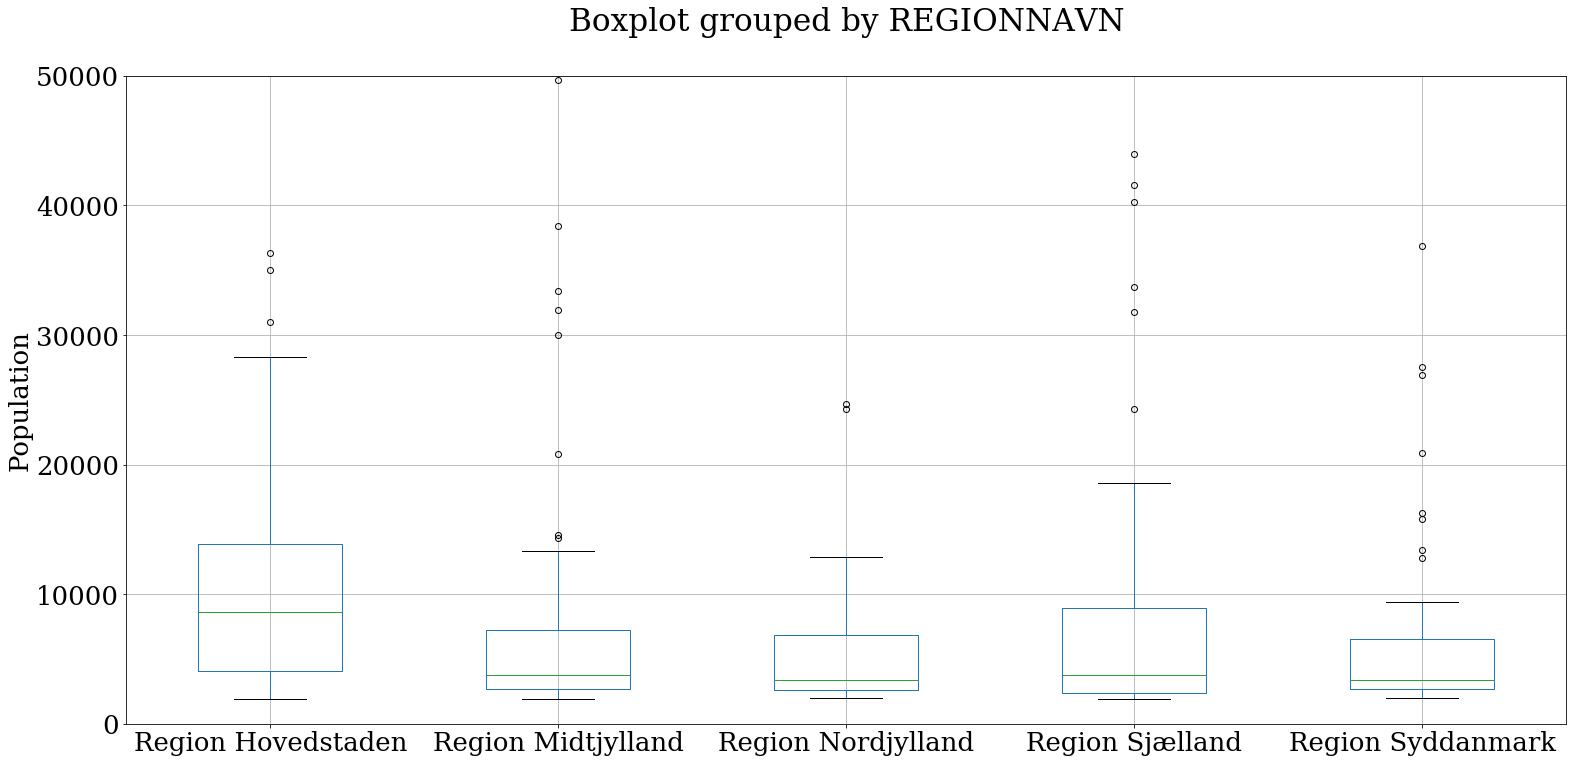

In [166]:

import pylab


boxplot = DK_merged_reg[['Population','REGIONNAVN']].boxplot(by='REGIONNAVN',figsize=(25,12))

plt.xlabel('')
plt.ylabel('Population')
pylab.rc('font', family='serif', size=26)
plt.ylim([0,50000])
plt.title('')


In [170]:
DK_reg = r'DK_regions.json' # geojson file

# create a plain world map
DK_map = folium.Map(location=[Latitude_DK, Longitude_DK], zoom_start=7)



folium.GeoJson(
    DK_reg,
    name='DK_regions.json'
).add_to(DK_map)#DK_map.choropleth(geo_data=DK_reg)
# display map
folium.LayerControl().add_to(DK_map)


# add markers to the map
for lat, lon, poi, cluster, region, kode in zip(DK_merged_reg['Latitude'], DK_merged_reg['Longitude'], DK_merged_reg['City name'], DK_merged_reg['Cluster Labels'], DK_merged_reg['REGIONNAVN'], DK_merged_reg['REGIONKODE']):
    label = folium.Popup(str(poi) + '\n' + str(region) + ' Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        fill_color=rainbow[cluster-1],
        fill=True,
        color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(DK_map)

DK_map

Text(0.5, 1.0, '')

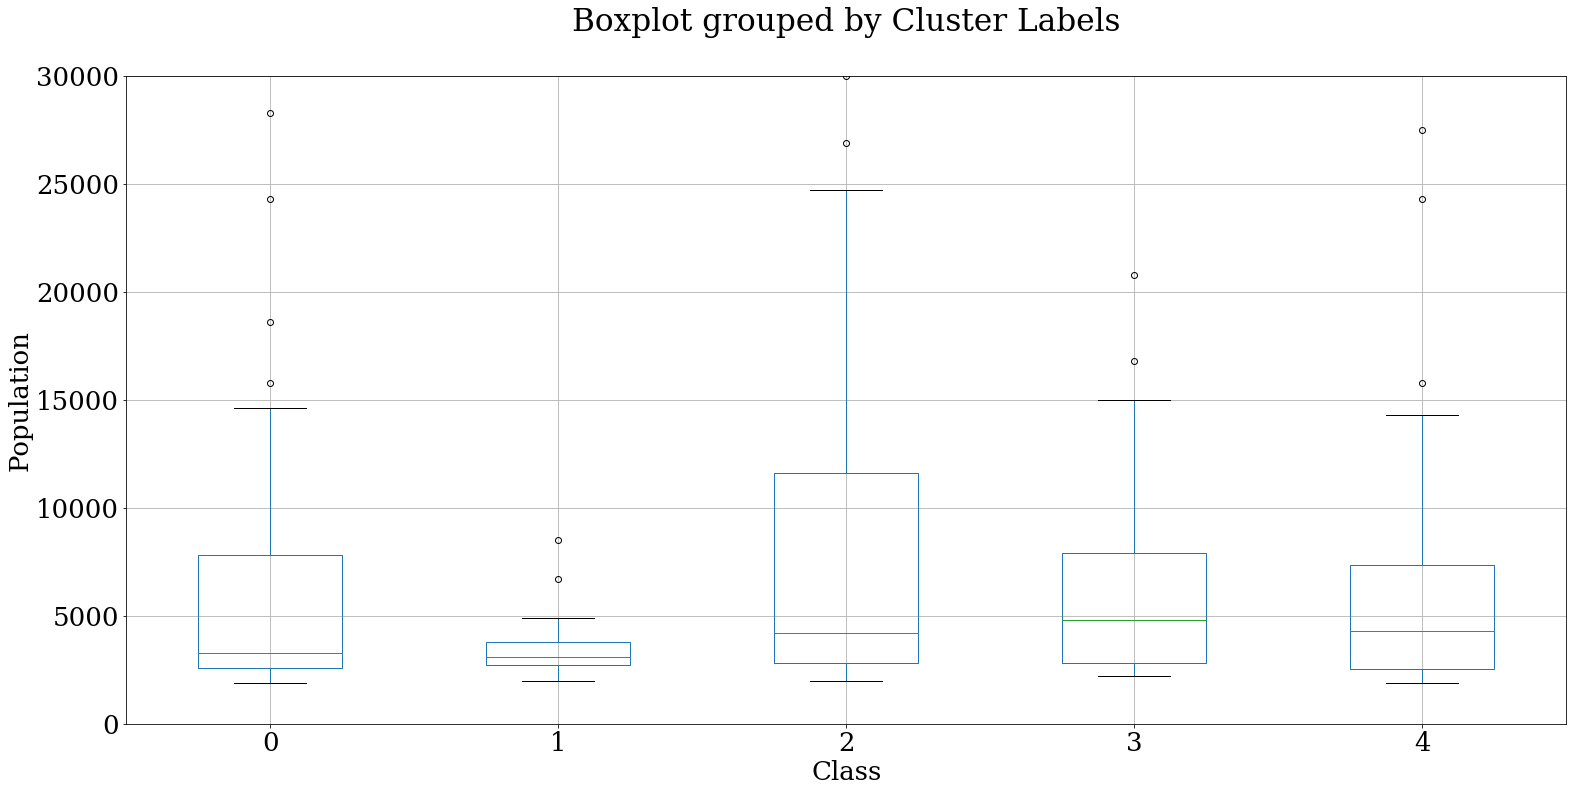

In [168]:

boxplot = DK_merged_reg[['Population','Cluster Labels']].boxplot(by='Cluster Labels',figsize=(25,12))

plt.xlabel('Class')
plt.ylabel('Population')
pylab.rc('font', family='serif', size=26)
plt.ylim([0,30000])
plt.title('')


## Study the different clusters in detail

In [206]:
clusterNumber = 3 # Pick the label of the cluster to study
q = DK_merged_reg.loc[DK_merged_reg['Cluster Labels'] == clusterNumber, DK_merged_reg.columns[[1] + list(range(5, DK_merged_reg.shape[1]))]]
display(q.describe())

Population  index_right
count     35.000000    35.000000
mean    6440.000000   111.971429
std     4809.378094    66.035412
min     2200.000000     1.000000
25%     2800.000000    66.000000
50%     4800.000000   145.000000
75%     7900.000000   159.500000
max    20800.000000   189.000000

In [209]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(q.iloc[:,0:6])

Population 1st Most Common Venue       2nd Most Common Venue  \
54        12000         Grocery Store                       Beach   
74         8600         Grocery Store              Ice Cream Shop   
105        5700         Grocery Store                       Beach   
201        2900         Grocery Store                       Hotel   
30        20800         Grocery Store        Fast Food Restaurant   
62        10800         Grocery Store                       Beach   
104        5800         Boat or Ferry               Grocery Store   
118        4900         Grocery Store                       Beach   
123        4800         Grocery Store               Train Station   
228        2600         Boat or Ferry                       Beach   
236        2500                 Beach                  Restaurant   
88         7200       Harbor / Marina                       Hotel   
103        5900                 Hotel               Grocery Store   
130        4500                 Beach               Grocery Store   
158        3700            Restaurant               Grocery Store   
170        3400       Harbor / Marina                        Café   
213        2800         Grocery Store              Ice Cream Shop   
36         5500         Grocery Store                       Beach   
41        15000                 Hotel             Harbor / Marina   
97         6400                 Hotel             Harbor / Marina   
154        3800         Grocery Store                 Gas Station   
161        3600         Train Station              History Museum   
211        2800                 Hotel               Grocery Store   
261        2300       Harbor / Marina                       Beach   
271        2200         Grocery Store           Convenience Store   
95         6700         Grocery Store                       Hotel   
244        2400       Harbor / Marina               Grocery Store   
34        16800         Grocery Store                       Beach   
256        2300                   Zoo                       Diner   
35         9300         Grocery Store                       Beach   
45        14300         Boat or Ferry  Construction & Landscaping   
47        13900         Grocery Store                        Café   
265        2200         Grocery Store                         Pub   
125        4700       Harbor / Marina                         Bar   
260        2300       Harbor / Marina                       Hotel   

       3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  
54           Harbor / Marina          Concert Hall               Restaurant  
74           Harbor / Marina    Seafood Restaurant                    Beach  
105              Fish Market                  Café     Gym / Fitness Center  
201                   Bakery            Restaurant             Concert Hall  
30                 Cafeteria                  Café          Harbor / Marina  
62           Harbor / Marina            Campground           Discount Store  
104  Scandinavian Restaurant                  Café                      Zoo  
118                      Gym                Bakery          Harbor / Marina  
123              Flower Shop                 Beach                   Market  
228                    Hotel        Discount Store                   Museum  
236   Furniture / Home Store           Flower Shop                   Forest  
88             Boat or Ferry         Grocery Store              Fish Market  
103          Harbor / Marina            Art Museum              Coffee Shop  
130                    Trail       Harbor / Marina                      Zoo  
158           Ice Cream Shop  Fast Food Restaurant              Supermarket  
170           Discount Store                   Zoo                  Exhibit  
213                    Beach      Football Stadium     Gym / Fitness Center  
36   Scandinavian Restaurant  Gym / Fitness Center           History Museum  
41            Scenic Lookout         G